In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
from sklearn.model_selection import LeaveOneOut, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm

In [35]:
# Загрузка предобработанных данных
root = "../.."
input_path = f"{root}/data/processed"

scaled_coverage_data = pd.read_csv(f"{input_path}/scaled/coverage.csv")
encoded_coverage_data  = pd.read_csv(f"{input_path}/encoded/coverage.csv")
catboost_coverage_data = pd.read_csv(f"{input_path}/catboost/coverage.csv")

In [36]:
def evaluate_kfold(X, y, model, model_name, n_splits=10, cat_features=None):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true, y_pred = [], []
    for tr, te in tqdm(kf.split(X), total=n_splits, desc=f"{model_name} {n_splits}-fold"):
        X_tr, X_te = X.iloc[tr], X.iloc[te]
        y_tr, y_te = y.iloc[tr], y.iloc[te]
        if cat_features and model_name.lower().startswith("catboost"):
            model.fit(X_tr, y_tr, cat_features=cat_features, verbose=False)
        else:
            model.fit(X_tr, y_tr)
        y_pred.extend(model.predict(X_te))
        y_true.extend(y_te.values)

    r2 = r2_score(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)

    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)
    mn, mx = min(y_true), max(y_true)
    plt.plot([mn, mx], [mn, mx], 'k--', lw=2)
    plt.title(f"{model_name} — {n_splits}-fold\nR²: {r2:.3f} | RMSE: {rmse:.3f}")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return r2, rmse

In [37]:
# Разделение признаков и целевой переменной
X_scaled = scaled_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_scaled = scaled_coverage_data["experiment.results.coverage.value"]

X_encoded  = encoded_coverage_data .drop(columns=["experiment.results.coverage.value"])
y_encoded  = encoded_coverage_data ["experiment.results.coverage.value"]

X_catboost = catboost_coverage_data.drop(columns=["experiment.results.coverage.value"])
y_catboost = catboost_coverage_data["experiment.results.coverage.value"]

# Выделение категориальных признаков для CatBoost
catboost_features = X_catboost.select_dtypes(include=["object", "category"]).columns.tolist()
X_catboost[catboost_features] = X_catboost[catboost_features].fillna('nan')

results = {}

Linear Regression 10-fold: 100%|██████████| 10/10 [00:00<00:00, 150.06it/s]


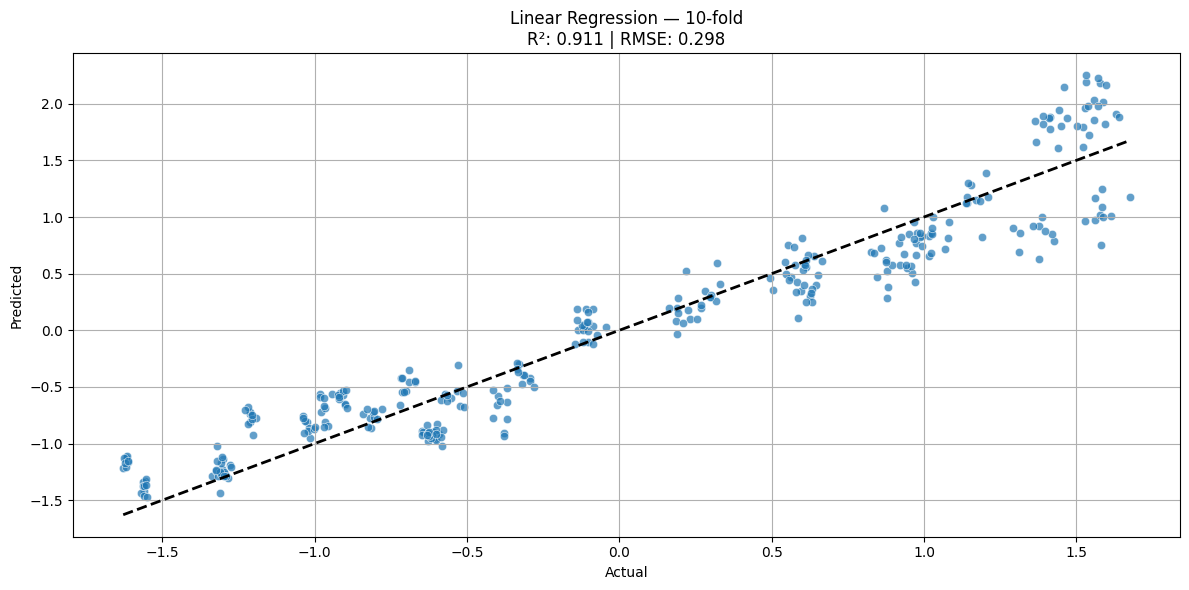

In [38]:
results["LinearRegression"] = evaluate_kfold(X_scaled, y_scaled, LinearRegression(), "Linear Regression")

In [39]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'C': np.logspace(-2, 2, 3),        # 0.01, 1, 1000
    'epsilon': np.logspace(-3, -1, 3), # 0.001, 0.01, 0.1
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=3)
grid_search.fit(X_scaled, y_scaled)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'C': np.float64(100.0), 'epsilon': np.float64(0.01), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9812974719926958


In [40]:
np.log10(0.04)

np.float64(-1.3979400086720375)

In [41]:
# Подбор гиперпараметров для SVR
param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(0, 1.1, 30),        
    'epsilon': np.logspace(-2, -1, 30),
    'gamma': ['scale']
}

# Кросс-валидация
cv = KFold(n_splits=10, shuffle=True, random_state=42)

# Grid Search
grid_search = GridSearchCV(SVR(), param_grid, cv=cv, scoring='r2', n_jobs=-1, verbose=2)
grid_search.fit(X_scaled, y_scaled)

# Результаты
print("Best parameters:", grid_search.best_params_)
print("Best R2 score (KFold):", grid_search.best_score_)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits
Best parameters: {'C': np.float64(12.589254117941675), 'epsilon': np.float64(0.03290344562312668), 'gamma': 'scale', 'kernel': 'rbf'}
Best R2 score (KFold): 0.9835213937844844


SVR 10-fold: 100%|██████████| 10/10 [00:00<00:00, 41.35it/s]


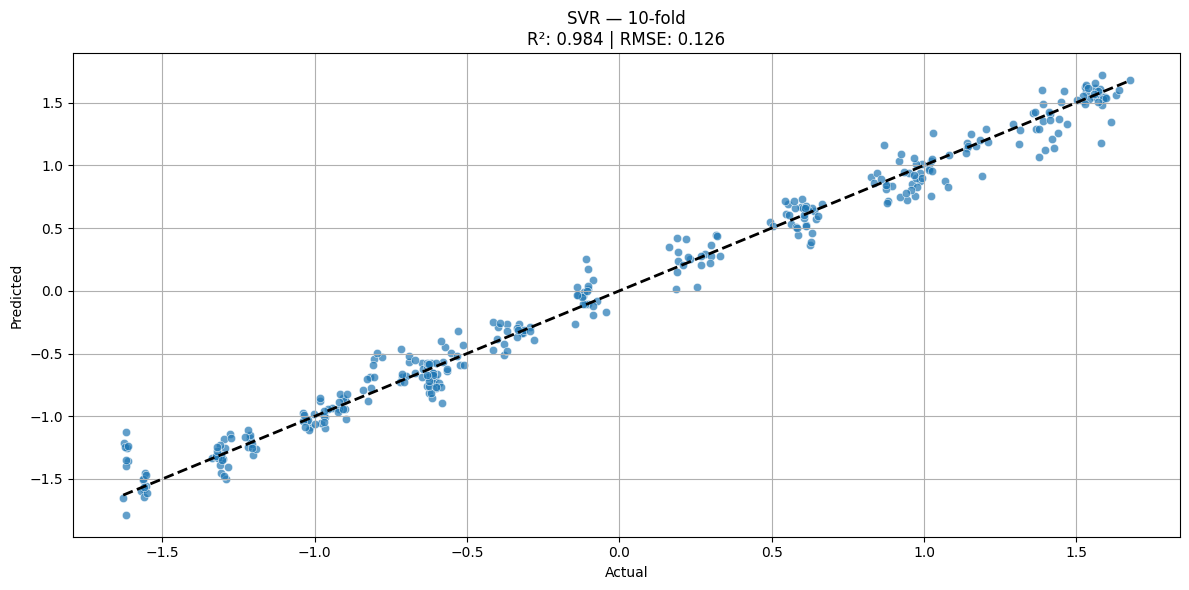

In [42]:
results["SVR"] = evaluate_kfold(X_scaled, y_scaled, SVR(**grid_search.best_params_), "SVR")

Random Forest 10-fold: 100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


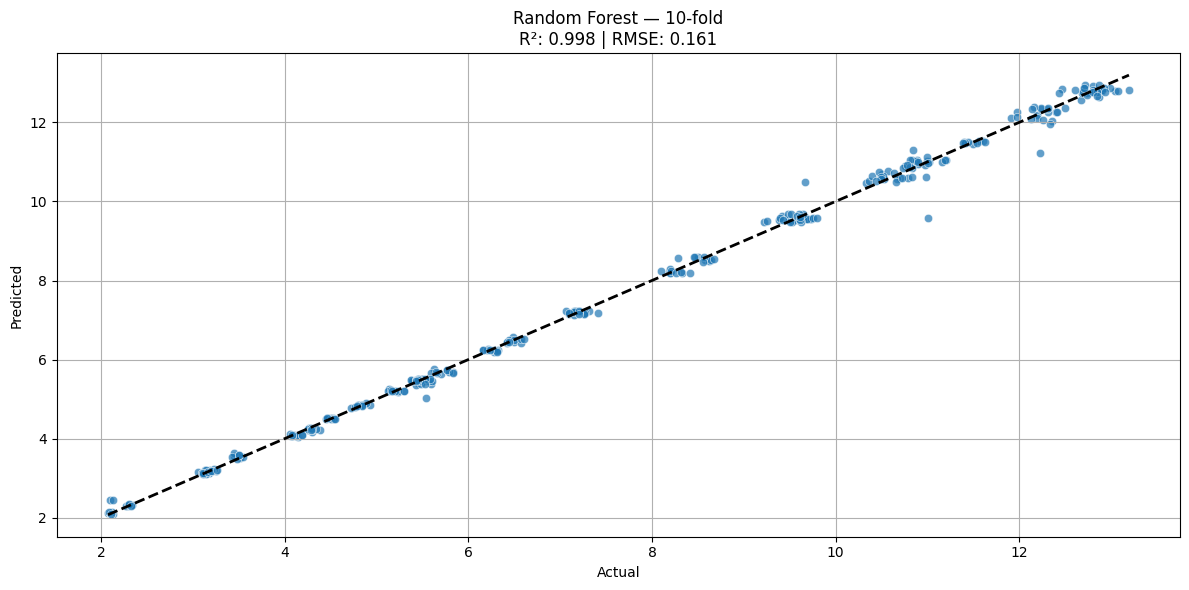

In [43]:
results["RandomForest"] = evaluate_kfold(X_encoded , y_encoded , RandomForestRegressor(), "Random Forest")

Gradient Boosting 10-fold: 100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


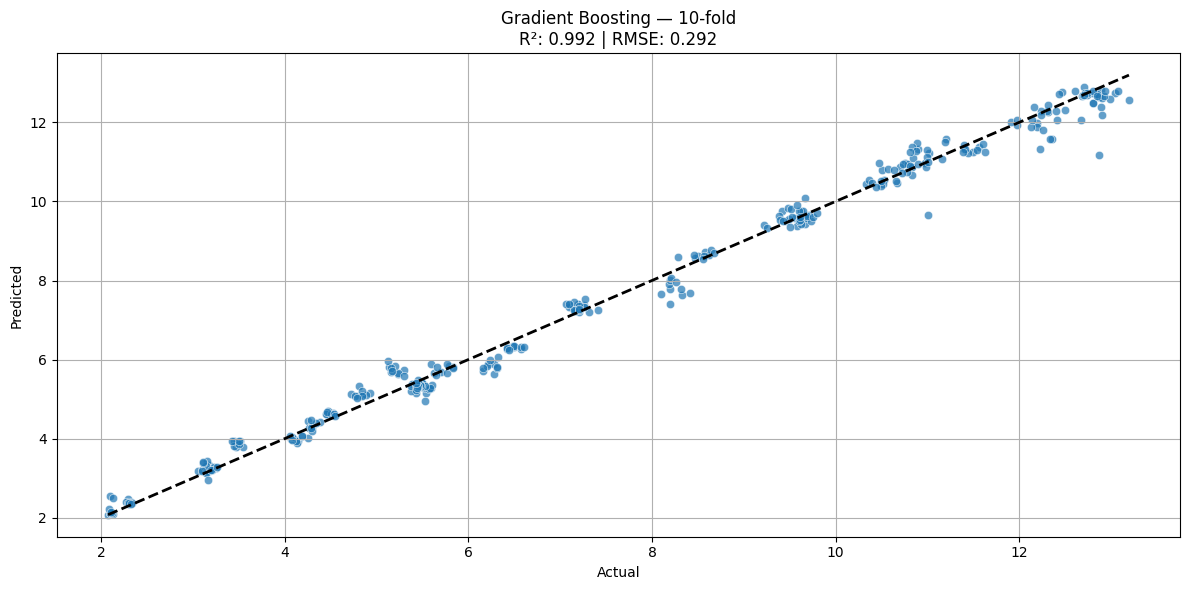

In [44]:
results["GradientBoosting"] = evaluate_kfold(X_encoded , y_encoded , GradientBoostingRegressor(), "Gradient Boosting")

XGBoost 10-fold: 100%|██████████| 10/10 [00:01<00:00,  5.91it/s]


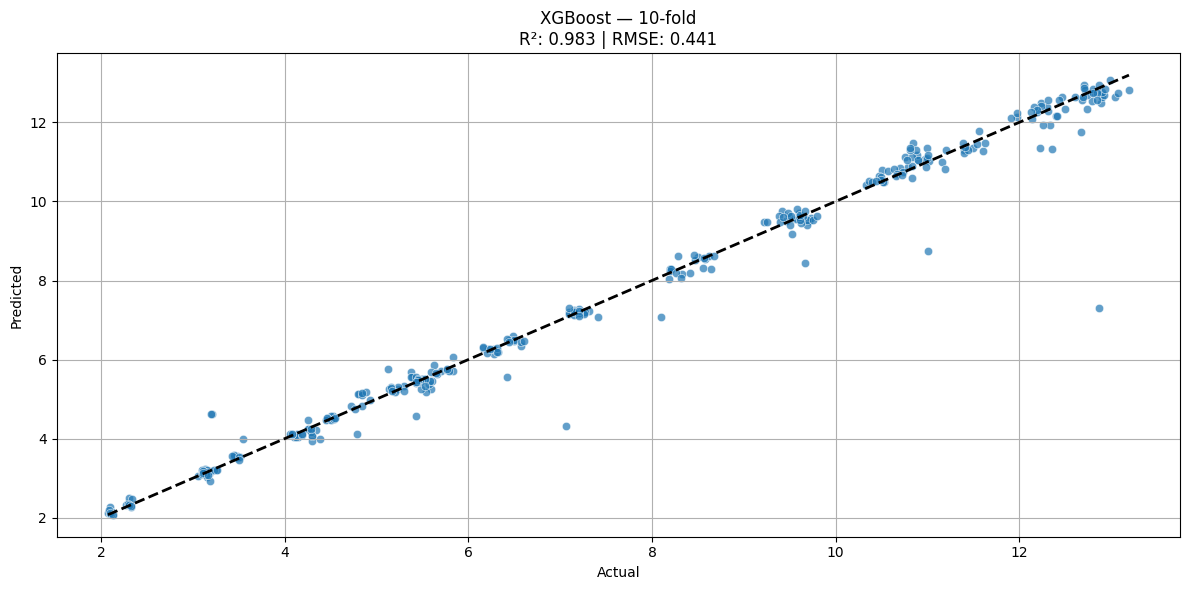

In [45]:
results["XGBoost"] = evaluate_kfold(X_encoded , y_encoded , XGBRegressor(), "XGBoost")

CatBoost 10-fold: 100%|██████████| 10/10 [06:07<00:00, 36.74s/it]


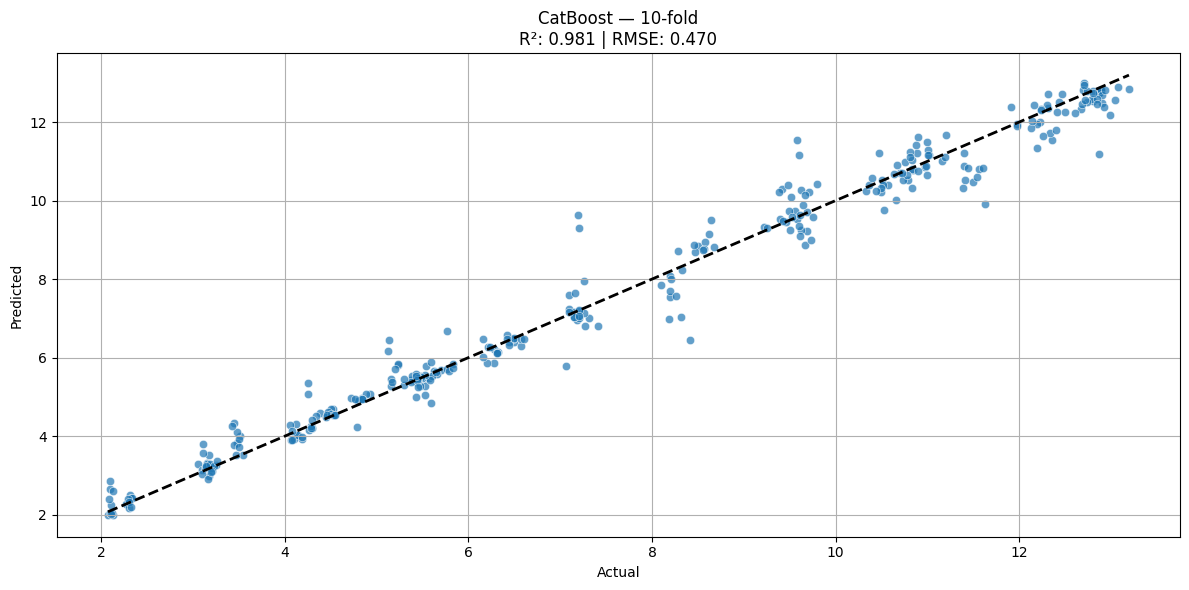

In [46]:
results["CatBoost"] = evaluate_kfold(X_catboost, y_catboost, 
                                              CatBoostRegressor(), 
                                              "CatBoost",
                                              cat_features=catboost_features)

In [47]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['R2', 'MAE'])
df_results = df_results.reset_index().rename(columns={'index': 'Model'})
df_results = df_results.sort_values(by='R2', ascending=False)
df_results 

,Model,R2,MAE
2,RandomForest,0.997702,0.161415
3,GradientBoosting,0.992461,0.292399
1,SVR,0.984242,0.125530
4,XGBoost,0.982886,0.440538
5,CatBoost,0.980538,0.469784
0,LinearRegression,0.911293,0.297838
